In [1]:
# %config IPython.highlighting_style = 'monokai'

# Clustering

Clustering techniques are unsupervised learning algorithms that try to group unlabelled data into "clusters", using the (typically spatial) structure of the data itself. It has many [applications](https://en.wikipedia.org/wiki/Cluster_analysis#Applications).

The easiest way to demonstrate how clustering works is to simply generate some data and show them in action. We'll start off by importing the libraries we'll be using today.

In [2]:
# %load_ext tensorboard
# %tensorboard --logdir logs

In [3]:
#|export

import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [4]:
#|export
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Create data

In [5]:
#|export 
# define the number of clusters and the number of samples to be clustered
n_clusters=6
n_samples =250

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

In [6]:
#|export
centroids = torch.rand(n_clusters, 2)*70-35 

In [7]:
centroids

tensor([[ 26.759,  29.050],
        [ -8.200,  32.151],
        [ -7.669,   7.063],
        [-17.040,  20.555],
        [ 30.854, -25.677],
        [ 30.422,   6.551]])

In [8]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [9]:
centroids

tensor([[ 26.759,  29.050],
        [ -8.200,  32.151],
        [ -7.669,   7.063],
        [-17.040,  20.555],
        [ 30.854, -25.677],
        [ 30.422,   6.551]])

In [10]:
tensor([5.,5.])

tensor([5., 5.])

In [11]:
torch.diag(tensor([5.,5.]))

tensor([[5., 0.],
        [0., 5.]])

In [12]:
pb_m = centroids[0,:]

Each sample will be a 2D point or vector 

In [13]:
def sample(m): 
    return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [14]:
?MultivariateNormal

Init signature:
MultivariateNormal(
    loc,
    covariance_matrix=None,
    precision_matrix=None,
    scale_tril=None,
    validate_args=None,
)
Docstring:     
Creates a multivariate normal (also called Gaussian) distribution
parameterized by a mean vector and a covariance matrix.

The multivariate normal distribution can be parameterized either
in terms of a positive definite covariance matrix :math:`\mathbf{\Sigma}`
or a positive definite precision matrix :math:`\mathbf{\Sigma}^{-1}`
or a lower-triangular matrix :math:`\mathbf{L}` with positive-valued
diagonal entries, such that
:math:`\mathbf{\Sigma} = \mathbf{L}\mathbf{L}^\top`. This triangular matrix
can be obtained via e.g. Cholesky decomposition of the covariance.

Example:

    >>> m = MultivariateNormal(torch.zeros(2), torch.eye(2))
    >>> m.sample()  # normally distributed with mean=`[0,0]` and covariance_matrix=`I`
    tensor([-0.2102, -0.5429])

Args:
    loc (Tensor): mean of the distribution
    covariance_matrix (Ten

In [15]:
[sample(c) for c in centroids]

[tensor([[26.204, 26.349],
         [25.691, 30.213],
         [30.431, 28.693],
         [25.647, 30.033],
         [31.236, 30.093],
         [30.276, 26.987],
         [29.619, 31.949],
         [28.124, 32.035],
         [24.275, 29.255],
         [21.578, 28.565],
         [23.663, 27.102],
         [26.259, 32.890],
         [25.435, 28.909],
         [24.906, 29.790],
         [23.276, 31.277],
         [24.792, 27.706],
         [29.693, 30.587],
         [24.323, 28.256],
         [24.715, 27.579],
         [26.933, 30.226],
         [29.395, 28.079],
         [23.659, 26.174],
         [23.621, 29.131],
         [26.617, 30.561],
         [27.580, 29.443],
         [29.856, 28.053],
         [29.990, 30.965],
         [31.719, 30.220],
         [29.387, 30.305],
         [25.746, 27.325],
         [26.374, 30.222],
         [26.885, 30.004],
         [27.200, 26.492],
         [27.515, 32.850],
         [26.783, 28.293],
         [23.761, 27.741],
         [25.497, 31.412],
 

In [16]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

In [17]:
slices[0].shape

torch.Size([250, 2])

In [18]:
slices

[tensor([[28.975, 30.296],
         [25.243, 31.216],
         [24.484, 25.370],
         [25.737, 27.070],
         [26.821, 28.239],
         [27.776, 30.749],
         [27.106, 29.071],
         [25.541, 29.762],
         [29.967, 29.179],
         [24.757, 28.858],
         [25.981, 26.890],
         [25.295, 24.484],
         [24.198, 31.038],
         [27.313, 31.233],
         [23.879, 33.342],
         [24.676, 28.183],
         [25.392, 30.318],
         [26.417, 28.398],
         [29.788, 31.617],
         [24.198, 29.789],
         [26.885, 29.477],
         [26.753, 27.614],
         [27.774, 28.063],
         [30.543, 28.774],
         [27.667, 32.865],
         [29.366, 28.513],
         [28.282, 28.286],
         [27.537, 31.271],
         [28.893, 28.182],
         [31.669, 30.931],
         [25.198, 32.763],
         [26.384, 25.739],
         [26.278, 29.424],
         [26.951, 28.200],
         [28.870, 28.081],
         [24.742, 26.790],
         [32.348, 29.172],
 

Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

In [19]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

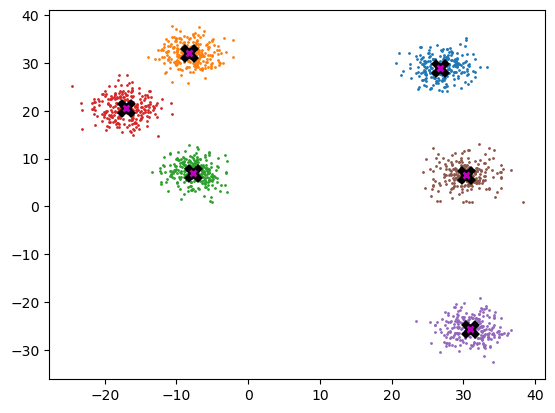

In [20]:
plot_data(centroids, data, n_samples)

## Mean shift

Most people that have come across clustering algorithms have learnt about **k-means**. Mean shift clustering is a newer and less well-known approach, but it has some important advantages:
* It doesn't require selecting the number of clusters in advance, but instead just requires a **bandwidth** to be specified, which can be easily chosen automatically
* It can handle clusters of any shape, whereas k-means (without using special extensions) requires that clusters be roughly ball shaped.

The algorithm is as follows:
* For each data point x in the sample X, find the distance between that point x and every other point in X
* Create weights for each point in X by using the **Gaussian kernel** of that point's distance to x
    * This weighting approach penalizes points further away from x
    * The rate at which the weights fall to zero is determined by the **bandwidth**, which is the standard deviation of the Gaussian
* Update x as the weighted average of all other points in X, weighted based on the previous step

This will iteratively push points that are close together even closer until they are next to each other.

In [21]:
midp = data.mean(0)
midp

tensor([ 9.235, 11.651])

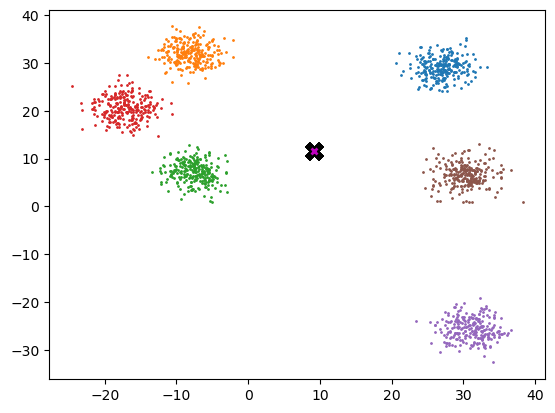

In [22]:
plot_data([midp]*6, data, n_samples)

So here's the definition of the gaussian kernel, which you may remember from high school...
 This person at the science march certainly remembered!

<img src="http://i.imgur.com/nijQLHw.jpg" width=400>

In [23]:
def gaussian(d, bw):
    return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [24]:
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

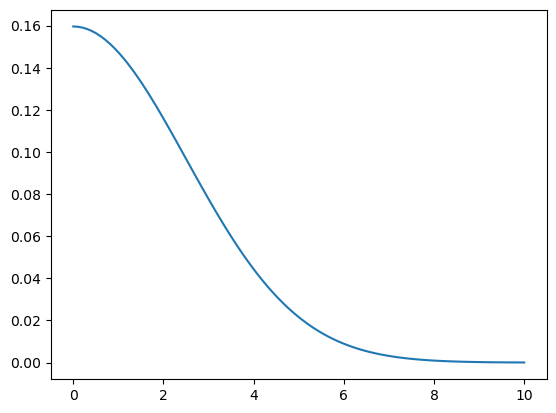

In [25]:
plot_func(partial(gaussian, bw=2.5))

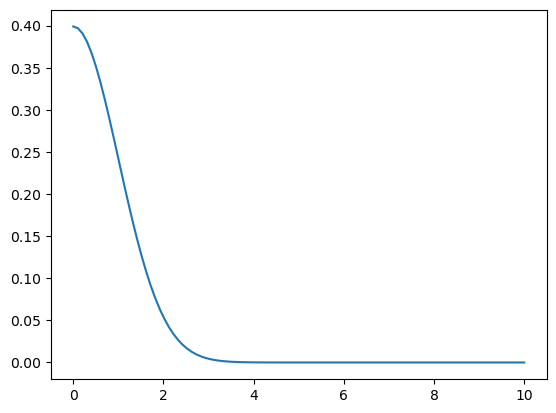

In [26]:
plot_func(partial(gaussian, bw=1))

In [27]:
partial

functools.partial

In our implementation, we choose the bandwidth to be 2.5. 

One easy way to choose bandwidth is to find which bandwidth covers one third of the data.

In [28]:
def tri(d, i): return (-d+i).clamp_min(0)/i

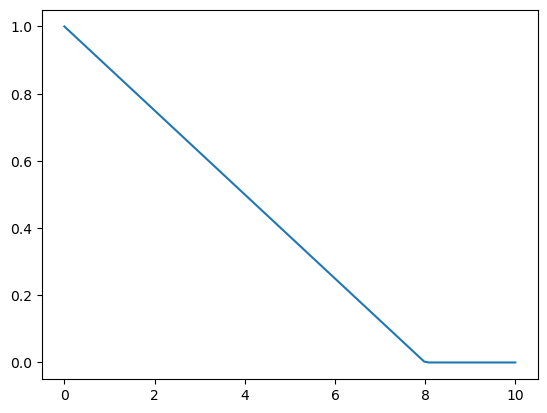

In [29]:
plot_func(partial(tri, i=8))

In [30]:
data, data.shape

(tensor([[28.975, 30.296],
         [25.243, 31.216],
         [24.484, 25.370],
         ...,
         [30.399,  1.060],
         [29.354,  5.243],
         [29.936,  5.269]]),
 torch.Size([1500, 2]))

In [31]:
X = data.clone()
x = data[0]

In [32]:
x

tensor([28.975, 30.296])

In [33]:
x.shape,X.shape,x[None].shape

(torch.Size([2]), torch.Size([1500, 2]), torch.Size([1, 2]))

In [34]:
(x[None]-X)[:8]

tensor([[ 0.000,  0.000],
        [ 3.733, -0.919],
        [ 4.491,  4.927],
        [ 3.239,  3.227],
        [ 2.154,  2.058],
        [ 1.199, -0.452],
        [ 1.869,  1.225],
        [ 3.434,  0.535]])

In [35]:
(x-X)[:8]

tensor([[ 0.000,  0.000],
        [ 3.733, -0.919],
        [ 4.491,  4.927],
        [ 3.239,  3.227],
        [ 2.154,  2.058],
        [ 1.199, -0.452],
        [ 1.869,  1.225],
        [ 3.434,  0.535]])

In [36]:
# rewrite using torch.einsum
dist = ((x-X)**2).sum(1).sqrt()
dist[:8]

tensor([0.000, 3.844, 6.667, 4.572, 2.979, 1.281, 2.235, 3.476])

In [37]:
weight = gaussian(dist, 2.5)
weight

tensor([    0.160,     0.049,     0.005,  ...,     0.000,     0.000,     0.000])

In [38]:
weight.shape,X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [39]:
weight[:,None].shape

torch.Size([1500, 1])

In [40]:
weight[:,None]*X

tensor([[    4.624,     4.835],
        [    1.235,     1.527],
        [    0.112,     0.116],
        ...,
        [    0.000,     0.000],
        [    0.000,     0.000],
        [    0.000,     0.000]])

In [41]:
def one_update(X):
    for i, x in enumerate(X):
        dist = torch.sqrt(((x-X)**2).sum(1))
#         weight = gaussian(dist, 2.5)
        weight = tri(dist, 8)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [42]:
def meanshift(data):
    X = data.clone()
    for it in range(5): one_update(X)
    return X

In [43]:
%time X=meanshift(data)

CPU times: user 440 ms, sys: 8.75 ms, total: 449 ms
Wall time: 448 ms


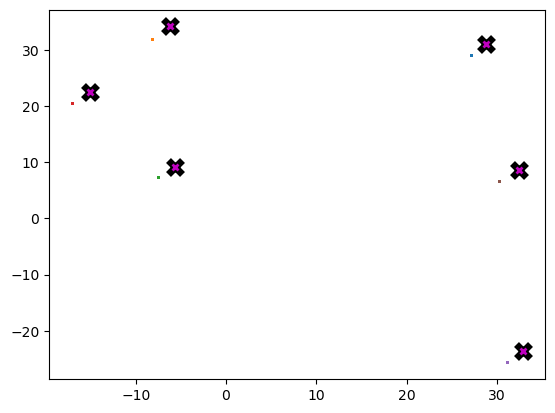

In [44]:
plot_data(centroids+2, X, n_samples)

## Animation

In [45]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [50]:
def do_one(d):
    if d: one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [51]:
# create your own animation
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

## GPU batched algorithm

To truly accelerate the algorithm, we need to be performing updates on a batch of points per iteration, instead of just one as we were doing.

In [52]:
bs=5
X = data.clone()
x = X[:bs]
x.shape,X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

In [53]:
def dist_b(a,b): return (((a[None]-b[:,None])**2).sum(2)).sqrt()

In [54]:
dist_b(X, x)

tensor([[ 0.000,  3.899,  4.834,  ..., 17.628, 22.610, 21.617],
        [ 3.899,  0.000,  4.978,  ..., 21.499, 26.508, 25.500],
        [ 4.834,  4.978,  0.000,  ..., 19.373, 24.757, 23.396],
        [ 3.726,  0.185,  4.969,  ..., 21.335, 26.336, 25.333],
        [ 6.273,  5.547,  1.615,  ..., 20.775, 26.201, 24.785]])

In [55]:
dist_b(X, x).shape

torch.Size([5, 1500])

In [56]:
X[None,:].shape, x[:,None].shape, (X[None,:]-x[:,None]).shape

(torch.Size([1, 1500, 2]), torch.Size([5, 1, 2]), torch.Size([5, 1500, 2]))

In [57]:
weight = gaussian(dist_b(X, x), 2)
weight

tensor([[    0.199,     0.030,     0.011,  ...,     0.000,     0.000,     0.000],
        [    0.030,     0.199,     0.009,  ...,     0.000,     0.000,     0.000],
        [    0.011,     0.009,     0.199,  ...,     0.000,     0.000,     0.000],
        [    0.035,     0.199,     0.009,  ...,     0.000,     0.000,     0.000],
        [    0.001,     0.004,     0.144,  ...,     0.000,     0.000,     0.000]])

In [58]:
weight.shape,X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

In [59]:
weight[...,None].shape, X[None].shape

(torch.Size([5, 1500, 1]), torch.Size([1, 1500, 2]))

In [60]:
num = (weight[...,None]*X[None]).sum(1)
num.shape

torch.Size([5, 2])

In [61]:
num

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.217],
        [231.302, 234.155]])

In [62]:
torch.einsum('ij,jk->ik', weight, X)

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.218],
        [231.302, 234.155]])

In [63]:
weight@X

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.218],
        [231.302, 234.155]])

In [64]:
div = weight.sum(1, keepdim=True)
div.shape

torch.Size([5, 1])

In [65]:
num/div

tensor([[26.376, 27.692],
        [26.101, 29.643],
        [28.892, 28.990],
        [26.071, 29.559],
        [29.323, 29.685]])

In [66]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            weight = gaussian(dist_b(X, X[s]), 2.5)
#             weight = tri(dist_b(X, X[s]), 8)
            div = weight.sum(1, keepdim=True)
            X[s] = weight@X/div
    return X

Although each iteration still has to launch a new cuda kernel, there are now fewer iterations, and the acceleration from updating a batch of points more than makes up for it.

In [67]:
data = data.cuda()

In [68]:
X = meanshift(data).cpu()

In [69]:
%timeit -n 5 _=meanshift(data, 1250).cpu()

5.25 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


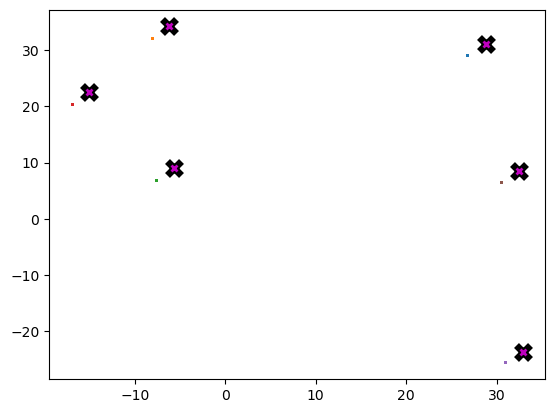

In [70]:
plot_data(centroids+2, X, n_samples)

**Homework:** implement k-means clustering, dbscan, locality sensitive hashing, or some other clustering, fast nearest neighbors, or similar algorithm of your choice, on the GPU. Check if your version is faster than a pure python or CPU version.

Bonus: Implement it in APL too!

Super bonus: Invent a new meanshift algorithm which picks only the closest points, to avoid quadratic time.

Super super bonus: Publish a paper that describes it :D